## Parametrize Charges example

#### Import basic packages

In [1]:
import numpy as np
import pandas as pd
import electric_emission_cost.costs as costs

#### Import a tariff .csv file

In [2]:
path_to_tariffsheet = "../electric_emission_cost/data/tariff.csv"
rate_df = pd.read_csv(path_to_tariffsheet, sep=",")

## Specify charge variants as a list of dictionaries
### Each with entries for:
- 'peak_demand_ratio': the ratio by which to scale peak demand charges, i.e. charges that are relevant for less than 24 hours
- 'peak_energy_ratio': the ratio by which to scale peak energy charges
- 'avg_demand_ratio': the ratio by which to scale the average demand charge, i.e. charges that are relevant for all 24 hours
- 'avg_energy_ratio': the ratio by which to scale the average energy charge
- 'peak_window_expand_hours': the ratio by which to scale the duration of the peak-period

The example below specifies 4 tariff variants as 4 entries in the list

In [3]:

variants = [
    # Double peak charges
    {
        'peak_demand_ratio': 2.0,
        'peak_energy_ratio': 2.0,
        'name': 'increase_peak'
    },
    # Half peak charges
    {
        'peak_demand_ratio': 0.5,
        'peak_energy_ratio': 0.5,
        'name': 'decrease_peak'
    },
    # Increased average charges
    {
        'avg_demand_ratio': 1.2,
        'avg_energy_ratio': 1.2,
        'name': 'increase_average'
    },
    # Modified peak windows
    {
        'peak_window_expand_hours': 4.0,
        'name': 'increase_window'
    }
]



### Specify date range to generate parametrized tariffs


In [4]:
# 1 week including 07-01 (00:00) through 07-07 (23:45)
start_dt = pd.Timestamp('2023-07-01')
end_dt = pd.Timestamp('2023-07-08')

### Generate new and baseline charge dictionaries

In [5]:
# original tariff dict
base_tariff_dict = costs.get_charge_dict(start_dt=start_dt, end_dt=end_dt, rate_data=rate_df)
# list of new tariff dicts for each variant
new_tariff_dicts = costs.parametrize_charge_dict(start_dt=start_dt, end_dt=end_dt, rate_data=rate_df, variants=variants)
# print to verify new tariffs
print(new_tariff_dicts.keys())

dict_keys(['original', 'increase_peak', 'decrease_peak', 'increase_average', 'increase_window'])


### Plot the energy and demand charges to visualize the parametrization

In [6]:
# make sure matplotlib is in your python environment before running this section
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

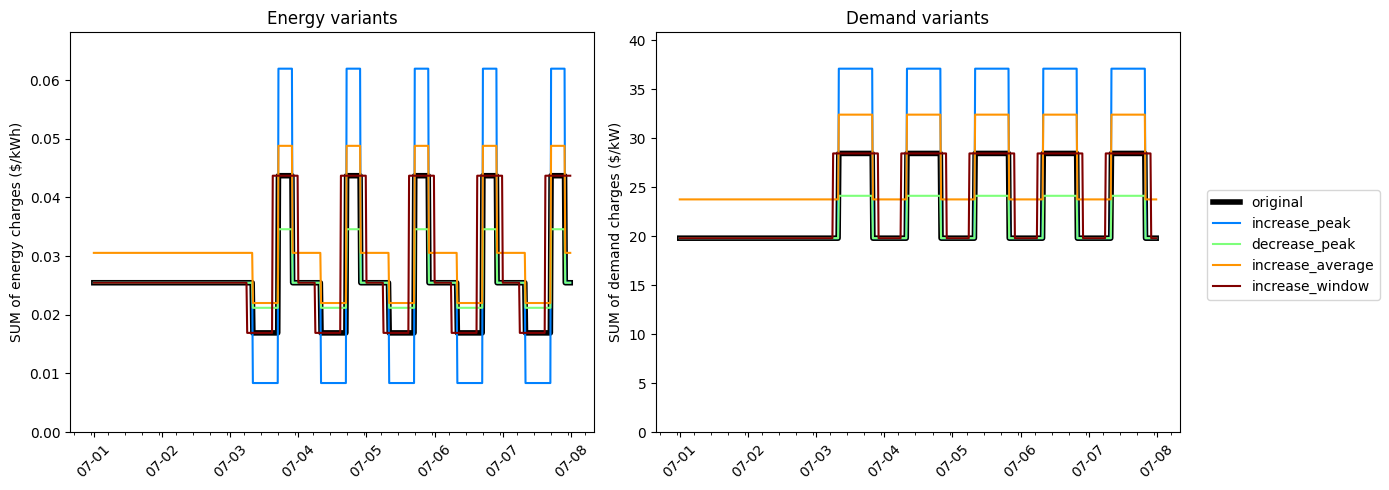

In [7]:
# Plot the energy costs and demand charges for each new charge dict
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = plt.cm.jet(np.linspace(0, 1, len(new_tariff_dicts)))
colors[0] = (0, 0, 0, 1)

max_demand_charge = 0 # for y limits
max_energy_charge = 0

# Create time index
time_index = pd.date_range(start=start_dt, end=end_dt - pd.Timedelta(minutes=15), freq='15min')

for (variant_key, tariff_dict), color in zip(new_tariff_dicts.items(), colors):
    sum_energy_array = np.zeros(len(list(tariff_dict.values())[1]))
    sum_demand_array = np.zeros(len(list(tariff_dict.values())[1]))
    
    for charge_key, charge_array in tariff_dict.items():
        if 'electric_energy' in charge_key:
            sum_energy_array += charge_array
        elif 'electric_demand' in charge_key:
            sum_demand_array += charge_array
    
    if variant_key == 'original':
        ax1.plot(time_index, sum_energy_array, color=color, label=variant_key, linewidth=4)
        ax2.plot(time_index, sum_demand_array, color=color, linewidth=4)
    else:
        ax1.plot(time_index, sum_energy_array, color=color, label=variant_key)
        ax2.plot(time_index, sum_demand_array, color=color)
   
    max_demand_charge = max(max_demand_charge, sum_demand_array.max())
    max_energy_charge = max(max_energy_charge, sum_energy_array.max())

# Format x-axis
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax1.set_ylim(0.0, 1.1*max_energy_charge)
ax2.set_ylim(0.0, 1.1*max_demand_charge)
ax1.set_ylabel('SUM of energy charges ($/kWh)')
ax2.set_ylabel('SUM of demand charges ($/kW)')
ax1.set_title('Energy variants')
ax2.set_title('Demand variants')

fig.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)
plt.tight_layout()
plt.tight_layout()